In [1]:
from itertools import product
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import scipy as sp
from scipy.linalg import svd
from scipy.sparse import dia_matrix, linalg, identity

from qiskit import Aer, transpile
from qiskit.circuit import QuantumCircuit
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit.opflow.primitive_ops import PauliSumOp, PauliOp
from qiskit.quantum_info import Pauli, Statevector

from banded_circulant_matrix import indices, unitary_iterate
from qsp import to_single_ancilla_qsp_angles
from qsvt import single_ancilla_qsp_circuit

## Target matrix $A$

In [2]:
alpha = 1
beta = 0.25
gamma = 0.25

num_qubits = 3
dim = 2 ** num_qubits

data = np.array([
    [alpha, gamma, 0, 0, 0, 0, 0, beta],
    [beta, alpha, gamma, 0, 0, 0, 0, 0],
    [0, beta, alpha, gamma, 0, 0, 0, 0],
    [0, 0, beta, alpha, gamma, 0, 0, 0],
    [0, 0, 0, beta, alpha, gamma, 0, 0],
    [0, 0, 0, 0, beta, alpha, gamma, 0],
    [0, 0, 0, 0, 0, beta, alpha, gamma],
    [gamma, 0, 0, 0, 0, 0, beta, alpha],
])

diagonals = np.array([[gamma, beta, alpha, gamma, beta]]).repeat(dim, axis=0).transpose()
offsets = np.array([- (dim - 1), - 1, 0, 1, dim - 1])
A = dia_matrix((diagonals, offsets), shape=(dim, dim)).tolil()

A_spec = sp.linalg.eigvalsh(A.toarray())

eig_max = max(A_spec)
eig_min = min(A_spec)
kappa = abs(eig_max / eig_min)

print(
    '-' * 80,
    f'matrix size: {dim} x {dim}',
    '-' * 80,
    'target matrix A:',
    A.toarray(),
    '-' * 80,
    'eigenvalues:',
    A_spec,
    '-' * 80,
    f'condition number: {kappa}',
    '-' * 80,
    sep = '\n'
)

--------------------------------------------------------------------------------
matrix size: 8 x 8
--------------------------------------------------------------------------------
target matrix A:
[[1.   0.25 0.   0.   0.   0.   0.   0.25]
 [0.25 1.   0.25 0.   0.   0.   0.   0.  ]
 [0.   0.25 1.   0.25 0.   0.   0.   0.  ]
 [0.   0.   0.25 1.   0.25 0.   0.   0.  ]
 [0.   0.   0.   0.25 1.   0.25 0.   0.  ]
 [0.   0.   0.   0.   0.25 1.   0.25 0.  ]
 [0.   0.   0.   0.   0.   0.25 1.   0.25]
 [0.25 0.   0.   0.   0.   0.   0.25 1.  ]]
--------------------------------------------------------------------------------
eigenvalues:
[0.5        0.64644661 0.64644661 1.         1.         1.35355339
 1.35355339 1.5       ]
--------------------------------------------------------------------------------
condition number: 3.0
--------------------------------------------------------------------------------


## Matrix block encoded by $U_A$
$$B = \frac{A}{s} = \frac{A}{4}$$

In [3]:
alpha = 1 / 4
beta = 1 / 16
gamma = 1 / 16

diagonals = np.array([[gamma, beta, alpha, gamma, beta]]).repeat(dim, axis=0).transpose()
offsets = np.array([- (dim - 1), - 1, 0, 1, dim - 1])
B = dia_matrix((diagonals, offsets), shape=(dim, dim)).tolil()
B_spec = sp.linalg.eigvalsh(B.toarray())
print(B_spec)
# print(linalg.inv(B).toarray())

[0.125      0.16161165 0.16161165 0.25       0.25       0.33838835
 0.33838835 0.375     ]


## Matrix inversion 
Polynomial approximation of $f(x) \approx \frac{\sqrt{\pi}}{24 x}$ for $\kappa = 3$
$$F = \frac{\sqrt{\pi}}{24} B^{-1}$$

In [4]:
S, U = sp.linalg.eigh(B.toarray())
W = np.sqrt(np.pi) / (4 * 6 * S)
F = U @ np.diag(W) @ U.T
print(F)
# print(F @ B)

[[ 0.34112703 -0.09143611  0.02461741 -0.00703355  0.00351677 -0.00703355
   0.02461741 -0.09143611]
 [-0.09143611  0.34112703 -0.09143611  0.02461741 -0.00703355  0.00351677
  -0.00703355  0.02461741]
 [ 0.02461741 -0.09143611  0.34112703 -0.09143611  0.02461741 -0.00703355
   0.00351677 -0.00703355]
 [-0.00703355  0.02461741 -0.09143611  0.34112703 -0.09143611  0.02461741
  -0.00703355  0.00351677]
 [ 0.00351677 -0.00703355  0.02461741 -0.09143611  0.34112703 -0.09143611
   0.02461741 -0.00703355]
 [-0.00703355  0.00351677 -0.00703355  0.02461741 -0.09143611  0.34112703
  -0.09143611  0.02461741]
 [ 0.02461741 -0.00703355  0.00351677 -0.00703355  0.02461741 -0.09143611
   0.34112703 -0.09143611]
 [-0.09143611  0.02461741 -0.00703355  0.00351677 -0.00703355  0.02461741
  -0.09143611  0.34112703]]


In [5]:
def subspace_sv(num_qubits, num_aux_qubits, sv):
    row_vec = np.zeros(2 ** num_qubits)
    keys = ["".join(k) for k in product("01", repeat=num_qubits)]
    
    for j, key in enumerate(keys):
        idx = int(key + "0" * num_aux_qubits, 2)
        row_vec[j] = np.real(sv[idx])
    
    return row_vec

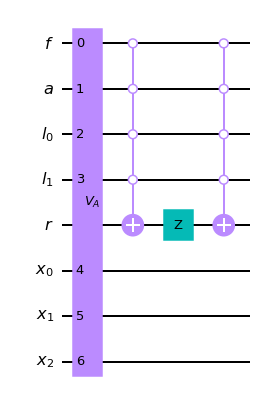

In [6]:
alpha = 1
beta = 0.25
gamma = 0.25

num_sys_qubits = 3
w = unitary_iterate(alpha, beta, gamma, num_sys_qubits, i=0, j=0, add_measurements=False)
w.draw("mpl", fold=-1)

In [7]:
# kappa = 3
# f(x) = np.sqrt(np.pi) / (4 * 6 * x)

angles = np.array([
    -2.5481255334285531,  0.4277601851098368,  2.3086408611540499,
    -2.0329181128165765,  1.1327197793073169, -0.3739308078738605,
     3.8767901690211120,  0.5906969541336257,  1.0713403943442550,
     2.8945960015784258, -1.0167176012488488, -0.1695681535011868,
    -1.0167176012481571, -0.2469966520098462, -2.0702522592436425,
     0.5906969541346488,  0.7351975154308896, -3.5155234614603761,
     1.1327197793090218, -2.0329181128206004, -3.9745444460287733,
     3.5693528386976605,  2.1642634469556588,
])

ref_state = QuantumCircuit(num_qubits, name="$\psi$")
ref_state.x(0)
ref_state.x(1)

backend = Aer.get_backend("aer_simulator_statevector")
backend.set_options(precision="double")

wy = transpile(w, backend=backend)
qc = single_ancilla_qsp_circuit(ref_state, wy, to_single_ancilla_qsp_angles(angles), add_measurements=False)
qc.draw("mpl", fold=-1)

In [8]:
num_aux_qubits = 6
amplitudes = []

for i in range(2 ** num_sys_qubits):
    # state preparation
    ref_state = QuantumCircuit(num_qubits, name="$\psi$")
    for k in indices(i):
        ref_state.x(k)
    
    qc = single_ancilla_qsp_circuit(ref_state, wy, to_single_ancilla_qsp_angles(angles), add_measurements=False)
    ai = subspace_sv(num_sys_qubits, num_aux_qubits, Statevector(qc).data)
    amplitudes.append(ai)
    print(ai)

[ 0.29769203 -0.05648359  0.00594757  0.00063242 -0.00080011  0.00063242
  0.00594757 -0.05648359]
[-0.05648359  0.29769203 -0.05648359  0.00594757  0.00063242 -0.00080011
  0.00063242  0.00594757]
[ 0.00594757 -0.05648359  0.29769203 -0.05648359  0.00594757  0.00063242
 -0.00080011  0.00063242]
[ 0.00063242  0.00594757 -0.05648359  0.29769203 -0.05648359  0.00594757
  0.00063242 -0.00080011]
[-0.00080011  0.00063242  0.00594757 -0.05648359  0.29769203 -0.05648359
  0.00594757  0.00063242]
[ 0.00063242 -0.00080011  0.00063242  0.00594757 -0.05648359  0.29769203
 -0.05648359  0.00594757]
[ 0.00594757  0.00063242 -0.00080011  0.00063242  0.00594757 -0.05648359
  0.29769203 -0.05648359]
[-0.05648359  0.00594757  0.00063242 -0.00080011  0.00063242  0.00594757
 -0.05648359  0.29769203]


### Errors analysis
- $v_i = \Vert F_{ij} - f(A) | i \rangle \Vert_1$
- Spectral norm (L1-norm): $\Vert v_i \Vert_1 / \sqrt{N} < \epsilon$ 

In [9]:
l1_norms = []
for vec1, vec2 in zip(F, amplitudes):
    l1_norms.append(LA.norm(vec1 - vec2, ord=1) / np.sqrt(8))

print(l1_norms)

[0.06022023350318226, 0.06022023350318, 0.0602202335031828, 0.060220233503185075, 0.060220233503181037, 0.060220233503181335, 0.06022023350318457, 0.060220233503185505]


## Matrix inversion 
Polynomial approximation of $f(x) \approx \frac{1}{2 \kappa x}$ for $\kappa = 8$
$$F = \frac{1}{2 \kappa} B^{-1}$$

In [10]:
S, U = sp.linalg.eigh(B.toarray())
# f(x) = erf(beta * x) / (2 * kappa * x)
kappa = 8
beta = 13.1598108570655
W = sp.special.erf(beta * S) / (2 * kappa * S)
F = U @ np.diag(W) @ U.T
print(F)
# print(F @ B)

[[ 0.28718579 -0.07595101  0.01958354 -0.00488233  0.00198047 -0.00488233
   0.01958354 -0.07595101]
 [-0.07595101  0.28718579 -0.07595101  0.01958354 -0.00488233  0.00198047
  -0.00488233  0.01958354]
 [ 0.01958354 -0.07595101  0.28718579 -0.07595101  0.01958354 -0.00488233
   0.00198047 -0.00488233]
 [-0.00488233  0.01958354 -0.07595101  0.28718579 -0.07595101  0.01958354
  -0.00488233  0.00198047]
 [ 0.00198047 -0.00488233  0.01958354 -0.07595101  0.28718579 -0.07595101
   0.01958354 -0.00488233]
 [-0.00488233  0.00198047 -0.00488233  0.01958354 -0.07595101  0.28718579
  -0.07595101  0.01958354]
 [ 0.01958354 -0.00488233  0.00198047 -0.00488233  0.01958354 -0.07595101
   0.28718579 -0.07595101]
 [-0.07595101  0.01958354 -0.00488233  0.00198047 -0.00488233  0.01958354
  -0.07595101  0.28718579]]


In [11]:
# kappa = 8
# error = 0.01

angles = np.array([
    1.580297653129814e+00, -2.183970335983414e-02, 3.531039623029616e-02, 
    -2.963453820835727e-02, 2.203134178113574e-02, -5.315807673466162e-04, 
    4.306026715870437e-02, -2.008022043623600e-02, 4.427250807007087e-02, 
    -2.750639713505947e-02, 1.312413898658997e-01, 2.741609536111113e-03, 
    1.550195031565832e-01, 2.029209739346619e-01, -8.104869399920599e-03, 
    5.138551495694907e-01, -9.862026952595644e-01, 3.458077529112235e-01, 
    8.781247623438849e-01, -3.606303704516873e-02, 2.223160973085850e-01, 
    -1.067838051600757e-01, -3.074084357447426e-01, -1.105413652260848e+00, 
    4.216917975084344e-02, -6.004497536656759e-02, 4.216917975963808e-02, 
    -1.105413652261079e+00, -3.074084357474234e-01, -1.067838051714909e-01, 
    2.223160972985473e-01, -3.606303704117078e-02, 8.781247623444431e-01, 
    3.458077529058556e-01, -9.862026952553345e-01, 5.138551495789044e-01, 
    -8.104869397393768e-03, 2.029209739277027e-01, 1.550195031589094e-01, 
    2.741609539019295e-03, 1.312413898635375e-01, -2.750639713351074e-02, 
    4.427250807047904e-02, -2.008022043641176e-02, 4.306026715892532e-02, 
    -5.315807676130529e-04, 2.203134178133675e-02, -2.963453820821194e-02, 
    3.531039623018362e-02, -2.183970335981388e-02, 9.501326334951621e-03,
])

num_aux_qubits = 6
amplitudes = []

for i in range(2 ** num_sys_qubits):
    # state preparation
    ref_state = QuantumCircuit(num_qubits, name="$\psi$")
    for k in indices(i):
        ref_state.x(k)
    
    qc = single_ancilla_qsp_circuit(ref_state, wy, to_single_ancilla_qsp_angles(angles), add_measurements=False)
    ai = subspace_sv(num_sys_qubits, num_aux_qubits, Statevector(qc).data)
    amplitudes.append(ai)
    print(ai)

[ 0.28715497 -0.07601195  0.01957411 -0.0047108   0.00189139 -0.0047108
  0.01957411 -0.07601195]
[-0.07601195  0.28715497 -0.07601195  0.01957411 -0.0047108   0.00189139
 -0.0047108   0.01957411]
[ 0.01957411 -0.07601195  0.28715497 -0.07601195  0.01957411 -0.0047108
  0.00189139 -0.0047108 ]
[-0.0047108   0.01957411 -0.07601195  0.28715497 -0.07601195  0.01957411
 -0.0047108   0.00189139]
[ 0.00189139 -0.0047108   0.01957411 -0.07601195  0.28715497 -0.07601195
  0.01957411 -0.0047108 ]
[-0.0047108   0.00189139 -0.0047108   0.01957411 -0.07601195  0.28715497
 -0.07601195  0.01957411]
[ 0.01957411 -0.0047108   0.00189139 -0.0047108   0.01957411 -0.07601195
  0.28715497 -0.07601195]
[-0.07601195  0.01957411 -0.0047108   0.00189139 -0.0047108   0.01957411
 -0.07601195  0.28715497]


### Errors analysis
- $v_i = \Vert F_{ij} - f(A) | i \rangle \Vert_1$
- Spectral norm (L1-norm): $\Vert v_i \Vert_1 / \sqrt{N} < \epsilon$ 

In [12]:
l1_norms = []
for vec1, vec2 in zip(F, amplitudes):
    l1_norms.append(LA.norm(vec1 - vec2, ord=1) / np.sqrt(8))

print(l1_norms)

[0.00021343952434373897, 0.00021343952434212574, 0.00021343952434405407, 0.0002134395243422073, 0.00021343952434370103, 0.00021343952434181975, 0.00021343952434324564, 0.0002134395243451098]
